<a href="https://colab.research.google.com/github/beckerman1101/daily_accum_mapping/blob/main/morning_weather_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup cells
### Installing necessary python packages

In [1]:
pip install cartopy cfgrib

### Setting up required packages
#### This cell will ask for Drive Access

In [2]:
#### ---- NECESSARY PYTHON PACKAGES ---- ####

# All of them should import, but if any errors arise, just add the missing packages
# to the cell above after cfgrib and re-run the notebook
# Most of them should be available within Colab's base environment

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature,NaturalEarthFeature
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.colors as mcolors
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
import matplotlib.font_manager as fm
from datetime import datetime, timedelta
import cfgrib
from scipy.spatial import cKDTree
import tqdm
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import requests
from zoneinfo import ZoneInfo
import zipfile
import os
import io
from io import BytesIO
from PIL import Image
import gzip
import shutil
import tarfile
from bs4 import BeautifulSoup
import re
import textwrap
from google.colab import drive
drive.mount('/content/drive')
os.environ['SHAPE_RESTORE_SHX'] = 'YES'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Installing CDOT Trebuchet Font, setting up variables for today (for use in labels & filemaking)

In [3]:
#### ---- FONT SETUP ---- ####

# Not sure if adding all of them is necessary because the plot looks good, but not taking chances here

treb = '/content/drive/My Drive/Morning Weather Report/TREBUC.TTF'
trebb = '/content/drive/My Drive/Morning Weather Report/TREBUCBD.TTF'
trebi = '/content/drive/My Drive/Morning Weather Report/TREBUCIT.TTF'
trebbi = '/content/drive/My Drive/Morning Weather Report/TREBUCBI.TTF'
fm.fontManager.addfont(treb)
fm.fontManager.addfont(trebb)
fm.fontManager.addfont(trebi)
fm.fontManager.addfont(trebbi)
treb = fm.FontProperties(fname=treb)
trebb = fm.FontProperties(fname=trebb)
trebi = fm.FontProperties(fname=trebi)
trebbi = fm.FontProperties(fname=trebbi)

#### ---- DATE STRINGS ---- ####

# These strings are how every export is labeled, as well as the title

today = datetime.now(ZoneInfo('America/Denver'))
yesterday = today - timedelta(days=1)
todayst = today.strftime('%a %m/%d')
yesterdayst = yesterday.strftime('%a %m/%d')
todaystr = today.strftime('%Y%m%d')
mo = today.strftime('%Y%m')
ts = today.strftime('%I:%M %p')
todaystr

'20250303'

### Importing Highway logos, establishing Colorado lat/lon bounds, importing and processing necessary roadway/CDOT shapefiles

In [4]:
#### ---- LOGO & SHAPEFILE IMPORTS ---- ####

# These open up the highway logos and cdot for the top of the figure. The cdot logo is a mess, see the final few lines of the notebook

cdotlogo = mpimg.imread('/content/drive/My Drive/Morning Weather Report/Images/image (1).png')
nws = mpimg.imread('/content/drive/My Drive/Morning Weather Report/Images/nwslogo.png')
us160 = mpimg.imread('/content/drive/My Drive/Morning Weather Report/Images/US_160.png')
us550 = mpimg.imread('/content/drive/My Drive/Morning Weather Report/Images/US_550.png')
us50 = mpimg.imread('/content/drive/My Drive/Morning Weather Report/Images/US_50.png')
us40 = mpimg.imread('/content/drive/My Drive/Morning Weather Report/Images/US_40.png')
us285 = mpimg.imread('/content/drive/My Drive/Morning Weather Report/Images/US_285.png')
i25 = mpimg.imread('/content/drive/My Drive/Morning Weather Report/Images/I-25.png')
i70 = mpimg.imread('/content/drive/My Drive/Morning Weather Report/Images/I-70.png')
i76 = mpimg.imread('/content/drive/My Drive/Morning Weather Report/Images/I-76.png')

# Colorado bounds and padding for the maps. This can be adjusted if we want to scale the mapping
co_bounds = [-109.05,-102.05,37,41]
x = .15

# Placefiles for counties, interstates, state highways, and manipulating the regions shapefile to plot properly
# My laziness backfired on the cdot boundaries. I ignored the projection file and had to manually manipulate it, but this works
# Don't fix what ain't broken

counties = gpd.read_file('/content/drive/My Drive/Morning Weather Report/Shapefiles/tl_2019_08_county.shp')
cdot = gpd.read_file('/content/drive/My Drive/Morning Weather Report/Shapefiles/MaintenanceSections.shp').set_crs(epsg=26913)
cdot = cdot.to_crs(epsg=32662)
cdot_bounds = cdot.total_bounds
x_scale = (co_bounds[1]-co_bounds[0])/(cdot_bounds[2]-cdot_bounds[0])
y_scale = (co_bounds[3]-co_bounds[2])/(cdot_bounds[3]-cdot_bounds[1])
cdot = cdot.scale(x_scale, y_scale, origin=(0,0))
cdot_bounds2 = cdot.total_bounds
lx = cdot_bounds2[0]
ly = cdot_bounds2[1]
cdot = cdot.translate(xoff=co_bounds[0]-lx, yoff=co_bounds[2]-ly)
sh = gpd.read_file('/content/drive/My Drive/Morning Weather Report/Shapefiles/tl_2021_08_prisecroads.shp')
interstates = gpd.read_file('/content/drive/My Drive/Morning Weather Report/Shapefiles/us_interstate_highways.shp')

### Establishing colorbars and their labels for snowfall and WWA Display

In [5]:
#### ---- CREATING COLORBARS ---- ####

# Snowfall colorbar
colors_snow = [
    '#FFFFFF', '#E7E7E7', '#CBE0ED', '#89BFDF', '#5A9CCB', '#3675B2', '#3650AB',
    '#FFFFAD', '#FFD130', '#FFA030', '#E34130', '#B23030', '#883030', '#D7D7FF', '#B3A4E1',
    '#9775B8', '#7B458F', '#5A305B']
cmaps = mcolors.ListedColormap(colors_snow)
boundariess = [0,0.1,1,2,3,4,5,6,8,10,12,14,16,18,24,30,36,42]
norms = mcolors.BoundaryNorm(boundariess, cmaps.N)
snow_labels = ['','0.1"','1"','2"','3"','4"','5"','6"','8"','10"','12"','14"','16"','18"','24"','30"','36"','']

#WWA colorbar
wwa_colors = {
    "Red Flag Warning": "#F60093",
    "High Wind Warning": "#D6A330",
    "Blizzard Warning": "#F73B19",
    "Winter Weather Advisory": '#7B6AEB',
    "Winter Storm Warning": "#F865B3",
    "Winter Storm Watch": '#4E83B2'
    # Add other warnings and advisories as needed, grab the hexadecimal of the color from NWS
}
cmapw = mcolors.ListedColormap(list(wwa_colors.values()))
normw = mcolors.BoundaryNorm(np.arange(0, len(wwa_colors)+1), len(wwa_colors))

# Black colorbar

black_cmap = ListedColormap([(0, 0, 0, 1)])

### Query & process most recent AFD

In [6]:
#### ---- AFD QUERY ---- ####

#ChatGPT wrote this whole one except the last line. Generates a pretty little list out of the AFD text though

afd_url = "https://forecast.weather.gov/product.php?site=BOU&issuedby=BOU&product=AFD&format=CI&version=1&glossary=1"
response = requests.get(afd_url)
afd_text = response.text
soup = BeautifulSoup(afd_text, "html.parser")
clean_text = soup.get_text()
match = re.search(r"\.KEY MESSAGES\.(.*?)&&", clean_text, re.DOTALL)
key_messages = match.group(1).strip()
key_messages = re.sub(r"\n(?![-*])", " ", key_messages)
key_messages = re.sub(r"\s+", " ", key_messages).strip()
key_messages = re.sub(r'\([^\)]*\)', lambda m: m.group(0).replace('-', '±'), key_messages)
messages_list = re.split(r' - ', key_messages)
messages_list = [msg.strip() for msg in messages_list if msg.strip()]
messages_list = [msg.replace('±', '-') for msg in messages_list]
afdtext = messages_list[1:]

### Query & process WWA

In [7]:
#### ---- NWS WATCH, WARNING, AND ADVISORY DATA ---- ####

# Some of this filtering is a little overkill, but grabs only the Colorado winter-weather products
# If we want Dense Fog, Wind Chill, we can add them, but... this is enough for this graphic

# All of these queries that are ran download the file to the extracted file folder, we can keep for records

url = 'https://tgftp.nws.noaa.gov/SL.us008001/DF.sha/DC.cap/DS.WWA/current_all.tar.gz'
downloaded_file_path = f'{todaystr}_wwa.tar.gz'
extracted_folder = f'/content/drive/My Drive/Morning Weather Report/files/{todaystr}'
if not os.path.exists(extracted_folder):
    os.makedirs(extracted_folder)
response = requests.get(url)
with open(downloaded_file_path, 'wb') as f:
    f.write(response.content)
with tarfile.open(downloaded_file_path, 'r:gz') as tar:
    tar.extractall(path=extracted_folder, filter='fully_trusted')
shapefile_path = None
for file in os.listdir(extracted_folder):
    if file.endswith('.shp'):
        shapefile_path = os.path.join(extracted_folder, file)
        break
if shapefile_path is None:
    print("No shapefile found in the extracted files.")
else:
    gdf = gpd.read_file(shapefile_path)

co = gdf[gdf['WFO'].isin(['KBOU' , 'KGJT' , 'KPUB' , 'KGLD'])]
co['Warning Color'] = co['PROD_TYPE'].map(wwa_colors)
co = co[pd.notna(co['Warning Color'])]
co = co.reset_index(drop=True)

/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


### Query & process NDFD & Gridded snowfall analysis, assign values to points

In [10]:
#### ---- NWS SNOWFALL DATA QUERIES ---- ####

# The file formats are different and have to be handled as such

# The forecast has to be processed to sum up through the next 12z step of the NDFD

fcst_url = "https://tgftp.nws.noaa.gov/SL.us008001/ST.opnl/DF.gr2/DC.ndfd/AR.crrocks/VP.001-003/ds.snow.bin"
fcst_name = f"/content/drive/My Drive/Morning Weather Report/files/{todaystr}/{todaystr}_ndfdsnow.bin"
response = requests.get(fcst_url, stream=True)
response.raise_for_status()
with open(fcst_name, 'wb') as file:
    for chunk in response.iter_content(chunk_size=8192):
        file.write(chunk)
snow_fcst = xr.open_dataset(fcst_name, engine='cfgrib', decode_timedelta=True)
pos1 = None
count = 0

for dt in times:
    hour = dt.astype('datetime64[h]').astype(int) % 24
    if hour == 12:
        count += 1
        if count == 2:
            pos1 = dt
            break


if pos1 is not None:
    mask = snow_fcst['valid_time'] == pos1
    pos = np.where(mask)[0][0]
else:
    pos = None
snow_m = snow_fcst.isel(step=slice(0,pos)).unknown.sum(dim='step')
end  = snow_fcst.step[pos].valid_time.values.astype('datetime64[s]').astype(datetime).replace(tzinfo=ZoneInfo("UTC")).astimezone(ZoneInfo("America/Denver")).strftime('%I%p %a')

df = 39.3701*snow_m
inter_factor = 8
new_lon = np.linspace(df.y[0].item(), df.y[-1].item(), df.sizes["y"] * inter_factor)
new_lat = np.linspace(df.x[0].item(), df.x[-1].item(), df.sizes["x"] * inter_factor)
snow_forecast = df.interp(x=new_lat, y=new_lon)

# The accumulation data is much easier to work with, but I'm still filtering out non-Colorado data

accum_url = f"https://www.nohrsc.noaa.gov/snowfall_v2/data/{mo}/sfav2_CONUS_24h_{todaystr}12.nc"
accum_name = f"/content/drive/My Drive/Morning Weather Report/files/{todaystr}/{todaystr}_gridded.nc"
response = requests.get(accum_url, stream=True)
with open(accum_name, "wb") as file:
    for chunk in response.iter_content(chunk_size=8192):
        file.write(chunk)
snow_accum = xr.open_dataset(accum_name)
df = 39.3701*snow_accum
df_co = df.where(df.lat>=co_bounds[2], drop=True).where(df.lat<=co_bounds[3], drop=True).where(df.lon>=co_bounds[0], drop=True).where(df.lon<=co_bounds[1], drop=True)
latlen = len(df_co.lat)
lonlen = len(df_co.lon)
inter_factor = 8
target_lat = np.linspace(co_bounds[2], co_bounds[3], latlen*inter_factor)
target_lon = np.linspace(co_bounds[0], co_bounds[1], lonlen*inter_factor)
snow_accumulation = df_co['Data'].interp(lat=target_lat, lon=target_lon, method='linear')

# Ignore this warning

<xarray.DataArray 'valid_time' (step: 13)> Size: 13B
array([False, False,  True, False, False, False, False, False, False,
       False, False, False, False])
Coordinates:
    time        datetime64[ns] 8B ...
  * step        (step) timedelta64[ns] 104B 0 days 06:00:00 ... 3 days 02:00:00
    surface     float64 8B ...
    valid_time  (step) datetime64[ns] 104B 2025-03-04T04:00:00 ... 2025-03-07

## Generate the Report
#### This will save to today's folder in the Morning Weather Report Drive folder

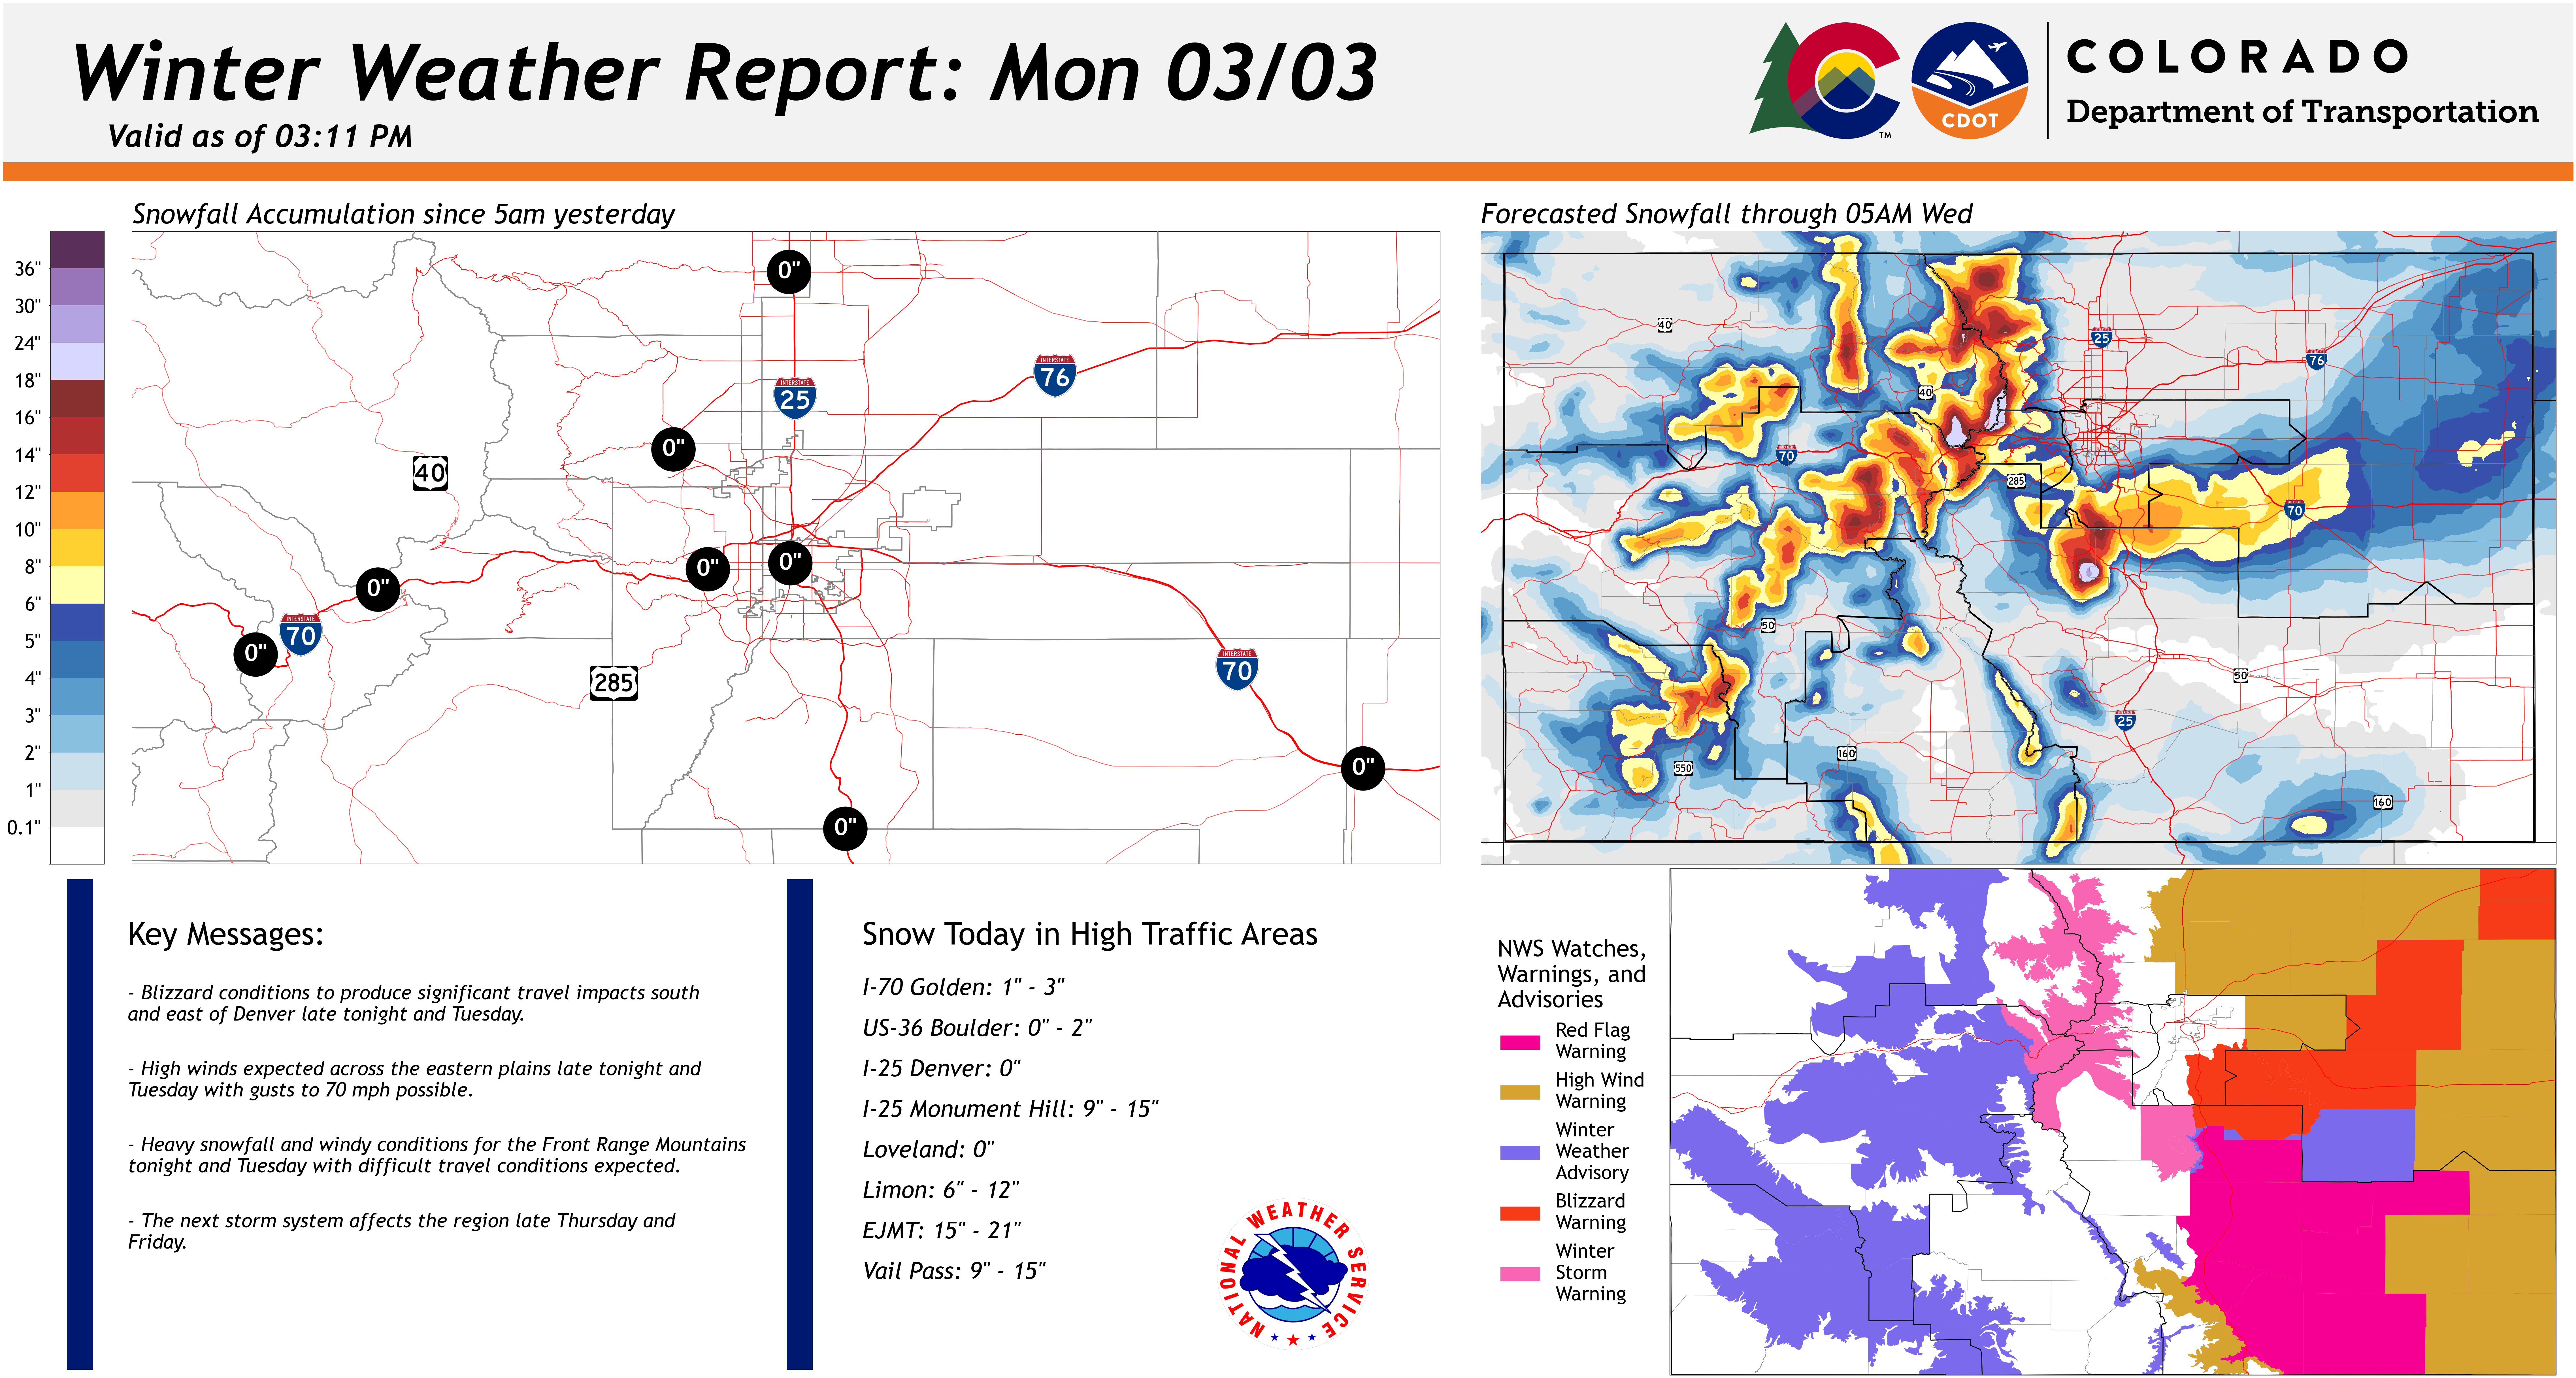

In [11]:
#### ---- REPORT GENERATION ---- ####

# Initializing the figure, gridspec, and subplots to place information in

fig = plt.figure(figsize=(90.7485, 45), tight_layout=True)
gs = fig.add_gridspec(2, 4, width_ratios=[0.05, 1.2187, 0.15, 0.85], height_ratios=[5, 4])
plt.rcParams['font.family'] = treb.get_name()
ax1 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(gs[0, 2:], projection=ccrs.PlateCarree())
ax3 = fig.add_subplot(gs[1, 0:2], projection=ccrs.PlateCarree())
cax = fig.add_subplot(gs[0, 0])
legend_ax = fig.add_subplot(gs[1, 2])
wwa_ax = fig.add_subplot(gs[1, 3], projection=ccrs.PlateCarree())

# Plotting the snow maps with counties, SHs, interstates, and CDOT sections

ax1.add_feature(cfeature.STATES)
counties.plot(ax=ax1, color='none', ec='gray', alpha=0.75, linewidth=3, zorder=14)
ax1.set_extent([-106.5, -103.5, 39.05, 40.5])
interstates.plot(ax=ax1, ec='r', linewidth=4)
sh.plot(ax=ax1, ec='r', linewidth=1.5, alpha=0.7)
ax1.imshow(i25, extent=[-105.029, -104.929, 40.067, 40.167], zorder=15) #40.11712370587691, -104.97956689965562
ax1.imshow(i70, extent=[-106.163, -106.063, 39.525, 39.625], zorder=15) #39.575197779681986, -106.11314206690821
ax1.imshow(i70, extent=[-104.015, -103.915, 39.445, 39.545], zorder=15) #39.496990632924955, -103.96489627317092
ax1.imshow(i76, extent=[-104.433, -104.333, 40.119, 40.219], zorder=15) #40.169462874547506, -104.38319636781574
ax1.imshow(us40, extent=[-105.856, -105.776, 39.905, 39.985], zorder=15) #39.94835413043858, -105.816784876115
ax1.imshow(us285, extent=[-105.45, -105.34, 39.424, 39.504], zorder=15) #39.464749902186234, -105.39577686384864

ax2.set_extent([co_bounds[0]-x, co_bounds[1]+x, co_bounds[2]-x, co_bounds[3]+x])
ax2.add_feature(cfeature.STATES, ec='k', linewidth=2)
counties.plot(ax=ax2, color='none', ec='gray', alpha=0.75, zorder=20)
sh.plot(ax=ax2, ec='r', linewidth=2, alpha=0.7)
interstates.plot(ax=ax2, ec='r', linewidth=3)
cdot.plot(ax=ax2, aspect=1, fc='none', ec='k', linewidth=4, zorder=12)

ax2.imshow(i25, extent=[-104.90, -104.75, 37.75, 37.9], zorder=15)
ax2.imshow(i25, extent=[-105.06, -104.91, 40.35, 40.5], zorder=15)
ax2.imshow(i70, extent=[-107.20, -107.05, 39.55, 39.7], zorder=15)
ax2.imshow(i70, extent=[-103.75, -103.6, 39.18, 39.33], zorder=15)
ax2.imshow(i76, extent=[-103.6, -103.45, 40.2, 40.35], zorder=15)
ax2.imshow(us40, extent=[-106.23, -106.13, 40, 40.1], zorder=15)
ax2.imshow(us40, extent=[-108, -107.9, 40.46, 40.56], zorder=15)
ax2.imshow(us50, extent=[-107.3, -107.2, 38.42, 38.52], zorder=15)
ax2.imshow(us50, extent=[-104.09, -103.99, 38.08, 38.18], zorder=15)
ax2.imshow(us550, extent=[-107.89, -107.76, 37.45, 37.55], zorder=15)
ax2.imshow(us285, extent=[-105.63, -105.50, 39.4, 39.5], zorder=15)
ax2.imshow(us160, extent=[-106.78, -106.65, 37.55, 37.65], zorder=15)
ax2.imshow(us160, extent=[-103.14, -103.01, 37.22, 37.32], zorder=15)

# Mapping the snow data on the respective maps

accum_map = snow_accumulation.plot(ax=ax1, x='lon', y='lat', transform=ccrs.PlateCarree(),
                              cmap=cmaps, norm=norms, add_colorbar=False)
fcst_map = snow_forecast.plot(ax=ax2, x='longitude', y='latitude', transform=ccrs.PlateCarree(),
                              cmap=cmaps, norm=norms, add_colorbar=False)
ax1.set_title('Snowfall Accumulation since 5am yesterday', x=0, fontsize=70, ha='left', style='italic', pad=20)
ax2.set_title(f'Forecasted Snowfall through {end}', x=0, fontsize=70, ha='left', style='italic', pad=20)

# Setting up the snow colorbar

cbar = fig.colorbar(accum_map, cax=cax, orientation='vertical', ticks=boundariess)
cbar.ax.yaxis.set_label_position("left")
cbar.ax.yaxis.tick_left()
cbar.ax.set_yticklabels(snow_labels)
cbar.ax.tick_params(labelsize=50, pad=20)
cax.set_anchor('W')  # Align the colorbar to the left

# Quick text wrapping function

def wrap_label(text, width=8):
    return "\n".join(textwrap.wrap(text, width=width, break_long_words=False))

# Whole lot of messy code for info on the bottom half of the report


ax3.set_xlim(0,50.7485)
ax3.set_ylim(0,20)
ax3.imshow(nws, extent=[44, 50, 1, 7], zorder=20)
ax3.text(1, 17, 'Key Messages:', fontsize=80, ha='left')
ax3.text(30, 17, 'Snow Today in High Traffic Areas', fontsize=80, ha='left')
y = 14
for i in range(len(afdtext)):
    string = wrap_label(afdtext[i], width=65)
    ax3.text(1, y, f'- {string}', fontsize=50, ha='left', style='italic')
    y-=3
disclaimer = "All data & messaging derived from NWS products. Interpolated snowfall is model-derived, and has not been processed for quality control."
ax3.axis('off')
#ax3.text(81, 1, disclaimer, fontsize=47, ha='right', style='italic')

# Snow Forecast values

# Based on point data, creates a range. If snow is 0<x<=3, the range will be 2" around
# the value, so 2" will produce 1-3"
# If 3<x<=8, the range is 4", and above 8", the range is 6"

table = pd.read_csv('/content/drive/My Drive/Morning Weather Report/fcst_locations.csv')
lats_lons = np.vstack([snow_forecast['latitude'].values.ravel(), snow_forecast['longitude'].values.ravel()]).T
kdtree = cKDTree(lats_lons)  # Create KDTree once
lats, lons, vals, ranges, fcst= [], [], [], [], []
for i in range(len(table)):
    lat = table.loc[i].lat
    lon = (360 + table.loc[i].lon)
    longi = table.loc[i].lon
    coords = np.array([[lat, lon]])
    dist, index = kdtree.query(coords)
    loc = snow_forecast.isel(y=index[0] // snow_forecast.sizes['x'], x=index[0] % snow_forecast.sizes['x'])
    fcst_val = snow_accumulation.sel(lat=lat, method='nearest').sel(lon=longi, method='nearest').values.max()
    val = loc.values.max()
    range_val = round(val)
    if range_val==0:
      ranges.append('0"')
    elif range_val<=3:
      buffer = 1
      ranges.append(f'{range_val-buffer}" - {range_val+buffer}"')
    elif range_val<=8:
      buffer = 2
      ranges.append(f'{range_val-buffer}" - {range_val+buffer}"')
    elif range_val>8:
      buffer = 3
      ranges.append(f'{range_val-buffer}" - {range_val+buffer}"')
    lats.append(lat)
    lons.append(lon)
    vals.append(val)
    fcst.append(fcst_val)
log = pd.DataFrame({'lat': lats, 'lon': lons, 'snow': vals, 'fore':fcst, 'range':ranges}, index=table.location.values)

ax1.scatter(log['lon'], log['lat'], c=log['fore'], cmap=black_cmap, s=12500, zorder=25, edgecolors='black', transform=ccrs.PlateCarree())
for i, row in log.iterrows():
    ax1.text(row['lon'], row['lat'], f'{int(row["fore"])}"', fontsize=60, ha='center', va='center', zorder=30, color='white', transform=ccrs.PlateCarree(), weight='bold')


y = 15
for i in log.index:
  loc = log.loc[i].name
  range_value = log.loc[i].range
  ax3.text(30, y, f'{loc}: {range_value}', fontsize=60, ha='left', style='italic')
  y-=1.6

# WWA Legend setup

wwa_ax.set_extent([-109.05, -102.05, 37, 41])
wwa_ax.add_feature(cfeature.STATES)
plt.rcParams['font.family'] = treb.get_name()
counties.plot(ax=wwa_ax, color='none', ec='gray', alpha=0.75)
interstates.plot(ax=wwa_ax, ec='r', linewidth=1.5)
cdot.plot(ax=wwa_ax, aspect=1, fc='none', ec='k', linewidth=2, zorder=12)
for i in range(len(co)):
    wwa_ax.add_geometries(co.loc[i].geometry, fc=co.loc[i]['Warning Color'], crs=ccrs.PlateCarree())
prod_types = co['PROD_TYPE'].unique()
colors = [co[co['PROD_TYPE'] == pt]['Warning Color'].iloc[0] for pt in prod_types]
# Step 3: Create legend handles with wrapped text
if len(co) == 0:
    # If `co` is empty, create a legend saying "None"
    legend_patches = [mpatches.Patch(color='gray', label='None')]  # You can change 'gray' to any color you prefer
else:
    # If `co` is not empty, proceed with generating the legend as usual
    prod_types = co['PROD_TYPE'].unique()
    colors = [co[co['PROD_TYPE'] == pt]['Warning Color'].iloc[0] for pt in prod_types]
    legend_patches = [mpatches.Patch(color=color, label=wrap_label(pt, width=10)) for pt, color in zip(prod_types, colors)]

legend = legend_ax.legend(handles=legend_patches, loc='center', bbox_to_anchor=(0.65, 0.5),
                          fontsize=50, title=wrap_label("NWS Watches, Warnings, and Advisories", width=16), title_fontsize=60, frameon=False)
 # Ensure the legend axis is not stretched
legend_ax.axis('off')
# Step 4: Adjust wwa_ax size to prevent top plots from shifting
  # Shrink only `wwa_ax` width

# Step 5: Add legend, keeping it inside the same GridSpec cell

# Graphic Design adds

fig.patches.append(mpatches.Rectangle((0, 0.95), 1, 0.13, transform=fig.transFigure, facecolor='#F2F2F2', zorder=-1))
fig.patches.append(mpatches.Rectangle((0, 0.940), 1, 0.015, transform=fig.transFigure, facecolor='#EF7521', zorder=-1))
fig.patches.append(mpatches.Rectangle((0.025, 0.0075), 0.01, 0.385, transform=fig.transFigure, facecolor='#001970', zorder=15))
fig.patches.append(mpatches.Rectangle((0.305, 0.0075), 0.01, 0.385, transform=fig.transFigure, facecolor='#001970', zorder=15))

# Final touches and exporting the figure
# If this part uses too much RAM, add dpi=50 to the end of the last line within the )
# The default value is 100, so just making a smaller export figure will use less memory

fig.suptitle(' ', x=0, y=1.07, fontsize=240, ha='left')
fig.text(0.025, 1.004, f'Winter Weather Report: {todayst}', fontsize=200, weight='bold', style='italic')
fig.text(0.04, 0.967, f'Valid as of {ts}', fontsize=80, weight='bold', style='italic')
fig.figimage(cdotlogo, 6050, 4250, zorder=20)
#plt.savefig(f"/content/drive/My Drive/Morning Weather Report/files/{todaystr}/{todaystr}_MWR.png", bbox_inches='tight')